In [2]:
import pandas as pd
import numpy as np
import os 
import sys
import glob 
import json
import importlib
import tqdm
import warnings
import matplotlib.pyplot as plt

In [3]:
#Make sure to run this only once, to make lobbying-market the working directory
parent_dir_name=os.path.basename(os.path.dirname(os.getcwd()))
if parent_dir_name=='lobbying-market':
    os.chdir(os.path.pardir)
    print(os.getcwd())
    utils_path= os.path.abspath('utils')
    sys.path.append(utils_path)

import preprocessing as pp
importlib.reload(pp)

with open("LDA_data/issue_list.json", 'r') as f:
    issue_list = json.load(f)

issue_df=pd.read_csv('LDA_data/data_by_issue.csv',index_col="issue")

c:\Users\nicoj\Documents\GitHub\lobbying-market


In [4]:
path_pattern='LDA_data/Filings_'
dirdict={str(i):path_pattern + str(i) for i in range(2013,2024)}
filepath_lists = {
    yearkey:
        [dirdict.get(yearkey)+'/'+filepath for filepath in os.listdir(dirdict.get(yearkey))] 
    for yearkey in dirdict
}

index_dict={
    'Q'+str(i+1): [6*i+j for j in range(6)]+[2*i+j for j in range(24,26)] for i in range(4)
}


file_list_dependency={
    yr_key : {
       qt_key:
           [filepath_lists[yr_key][i] for i in index_dict[qt_key]]
    for qt_key in index_dict
    }
    for yr_key in filepath_lists
}


In [6]:
try: preprocessed_file_dict.keys()
except: preprocessed_file_dict={}
dir_path='LDA_data/processed'
filelist= os.listdir(dir_path)
for yr in range(2013,2024):
    for j in range(4):
        key=str(yr)+str(j+1)
        i=(yr-2013)*4+j
        preprocessed_file_dict[key]=dir_path+'/'+filelist[i]  

In [ ]:
#df=pp.preprocess_data(pd.read_csv(file_list_dependency['2023']['Q4'][6]))
#This saves the preprocessed data into csv files
#It also saves the issue list
os.makedirs('LDA_data/processed', exist_ok=True) 
warnings.filterwarnings('ignore')
issue_set=set([])
Year_Keys=list(file_list_dependency.keys())
for yr_key in tqdm.tqdm(Year_Keys, desc = 'YEARS'):
    #print(yr_key)
    QT_Keys=list(file_list_dependency[yr_key].keys())
    for qt_key in tqdm.tqdm(QT_Keys ,desc = 'Quarters'):
        #print(qt_key)
        df=pp.preprocess_data(pd.read_csv(file_list_dependency[yr_key][qt_key][6]))
        filepath= 'LDA_data/processed/filings_'+yr_key+'_'+qt_key+'.csv'
        df.to_csv(filepath,index=False)
        issue_subset= set([col_name for col_name in df.columns if col_name.find('i_')>-1])
        issue_set= issue_set.union(issue_subset)

issue_set.remove('i_NUMBER')
issue_list=list(issue_set)
with open("LDA_data/issue_list.json", 'w') as f:
    json.dump(issue_list, f, indent=2)

In [9]:
#builds the file list to load additional files
files_to_avoid=[]
for yr_key in file_list_dependency:
    for qt_key in file_list_dependency[yr_key]:
        files_to_avoid.append(file_list_dependency[yr_key][qt_key][6])
for yr_key in filepath_lists:
    list_to_add= [path for path in filepath_lists[yr_key] if path not in files_to_avoid]
    additional_file_list=additional_file_list+list_to_add

NameError: name 'additional_file_list' is not defined

In [ ]:
#This saves the preprocessed additional data into csv files
# from additional_file_list
dirpath='LDA_data/processed_additional'
os.makedirs(dirpath, exist_ok=True) 
warnings.filterwarnings('ignore')
for path in tqdm.tqdm(additional_file_list):
        df=pp.preprocess_data(pd.read_csv(path))
        filename=os.path.basename(path)
        filepath= dirpath+'/'+filename
        df.to_csv(filepath,index=False)  


In [38]:
def add_data_by_issue(df,qt_key):
    df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])
    #print(df_to_load.shape)
    for issue_key in df['issue']:
        #print(issue_key)
        #filter by issue==1
        filtered_df= df_to_load[df_to_load[issue_key] == 1]
        
                
        #count the rows in issue and add to dataframe
        issue_count= filtered_df.shape[0]
        col_name= 'count_'+qt_key
        try: len(column_list_dict[colname])
        except: column_list_dict[colname]=[]
        df.loc[issue_df['issue']==issue_key,col_name]=issue_count
        #print(col_name+':'+str(issue_count))
        
        
        #count the number of na in both income and expenses then add to dataframe
        filter_na_income=filtered_df[filtered_df['income'].isna()]
        filter_na_expenses=filter_na_income[filter_na_income['expenses'].isna()]
        issue_count_na = filter_na_expenses.shape[0]
        col_name= 'nan_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_count_na
        #print(col_name+':'+str(issue_count_na))
        
        #sum income then add to dataframe
        issue_income= sum(filtered_df['income'].dropna())
        col_name= 'income_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_income
        #print(col_name +':'+str(issue_income))
        
        #sum expenses then add to dataframe
        issue_expenses= sum(filtered_df['expenses'].dropna())
        col_name= 'expenses_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_expenses
        #print(col_name+':'+str(issue_expenses))
        
        #sum total then add to dataframe
        issue_total=issue_income+issue_expenses
        col_name= 'total_'+qt_key
        df.loc[issue_df['issue']==issue_key,col_name]=issue_total
        
        
        
    

In [12]:
warnings.filterwarnings('ignore')
issue_df= pd.DataFrame(issue_list,columns=['issue'])
#add data to issue_df
for qt_key in tqdm.tqdm(preprocessed_file_dict):
    add_data_by_issue(issue_df,qt_key)

100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


In [14]:
issue_df.to_csv('LDA_data/data_by_issue.csv',index=False)

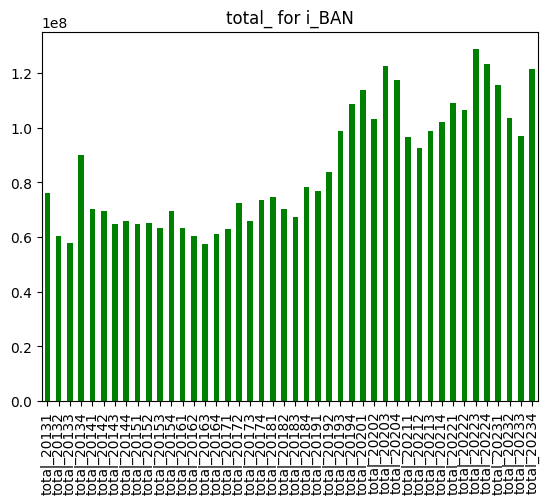

In [49]:
test_cols= issue_df.columns
prop_to_plot='total_'
issue_to_plot='i_BAN'
select_cols_list=[col for col in test_cols if col.find(prop_to_plot)>-1]
filtered_df=issue_df[select_cols_list].transpose()


# bar plot
filtered_df[issue_to_plot].plot(kind='bar',
        x='qt_key',
        y=prop_to_plot,
        color='green')
 
# set the title
plt.title(prop_to_plot + ' for ' +issue_to_plot)
 
# show the plot
plt.show()



In [9]:
client_dict={}

In [6]:
def add_clients_each_quarter(dict,qt_key):
    df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])
    num_of_rows=df_to_load.shape[0]
    #print(df_to_load.shape)
    column_list=['c_id','c_name']
    filtered_df= df_to_load[column_list]
    for i in range(num_of_rows):
        list_a = filtered_df.loc[i]
        try: 
            if list_a['c_name'] not in dict[str(list_a['c_id'])] : 
                dict[str(list_a['c_id'])].append(list_a['c_name'])
        except: dict[str(list_a['c_id'])]=[list_a['c_name']]
        
            
        
        
        
    

In [7]:
def add_clients_by_path(dict,path):
    df_to_load= pd.read_csv(path)
    num_of_rows=df_to_load.shape[0]
    #print(df_to_load.shape)
    column_list=['c_id','c_name']
    filtered_df= df_to_load[column_list]
    for i in range(num_of_rows):
        list_a = filtered_df.loc[i]
        try: 
            if list_a['c_name'] not in dict[str(list_a['c_id'])] : 
                dict[str(list_a['c_id'])].append(list_a['c_name'])
        except: dict[str(list_a['c_id'])]=[list_a['c_name']]

In [15]:
qt_key='20234'
df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])
num_of_rows=df_to_load.shape[0]
#print(df_to_load.shape)
column_list=['c_id','c_name']
filtered_df= df_to_load[column_list]
for i in range(num_of_rows):
    list_a = filtered_df.loc[i]
    try: 
        if list_a['c_name'] not in client_dict[str(list_a['c_id'])] : 
            client_dict[str(list_a['c_id'])].append(list_a['c_name'])
    except: client_dict[str(list_a['c_id'])]=[list_a['c_name']]

C:\Users\nicoj\AppData\Local\Temp\ipykernel_36160\1123778754.py:2: DtypeWarning: Columns (140) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_load= pd.read_csv(preprocessed_file_dict[qt_key])


In [67]:
client_dict['209471']

['WESTERN STATES REGIONAL COUNCIL OF CARPENTERS',
 'WESTERN STATES REGIONAL COUNCIL OF CARPENTERS (FORMERLY KNOWN AS SWMSRCC)']

In [14]:
[c_id_key for c_id_key in client_dict if len(client_dict[c_id_key])!= 1]

['209471']

In [ ]:
for qt_key in tqdm.tqdm(preprocessed_file_dict):
    add_clients_each_quarter(client_dict,qt_key)

In [23]:
with open("LDA_data/client_dict.json", 'w') as f:
    json.dump(client_dict, f, indent=2)

In [22]:
57732-len(client_dict)

0

In [17]:
client_dict={}

In [20]:
#all relevant files list
dirpath1='LDA_data/processed_additional'
filelist1= [dirpath1+'/'+filename for filename in os.listdir(dirpath1) ]
dirpath2='LDA_data/processed'
filelist2= [dirpath2+'/'+filename for filename in os.listdir(dirpath2) ]
loadfilelist=filelist1+filelist2

In [ ]:
for path in tqdm.tqdm(loadfilelist):
    add_clients_by_path(client_dict,path)

In [39]:
registrant_dict={}

In [40]:
def add_registrant_by_path(dict,path):
    df_to_load= pd.read_csv(path)
    num_of_rows=df_to_load.shape[0]
    #print(df_to_load.shape)
    column_list=['r_id','r_name','c_id']
    filtered_df= df_to_load[column_list]
    for i in range(num_of_rows):
        list_a = filtered_df.loc[i]
        registrant_id_key=str(list_a['r_id'])
        registrant_name_key=str(list_a['r_name'])
        client_id_key=str(list_a['c_id'])
        if registrant_id_key not in dict.keys():
            dict[registrant_id_key]=[[],[]]
        if registrant_name_key not in dict[registrant_id_key][0]: 
                dict[registrant_id_key][0].append(registrant_name_key)
        if client_id_key not in dict[registrant_id_key][1]: 
                dict[registrant_id_key][1].append(client_id_key)

In [ ]:
for path in tqdm.tqdm(loadfilelist):
    add_registrant_by_path(registrant_dict,path)

In [49]:
with open("LDA_data/registrant_dict.json", 'w') as f:
    json.dump(registrant_dict, f, indent=2)

In [43]:
len(registrant_dict)

8431

In [44]:
sum([len(registrant_dict[key][1])for key in registrant_dict])

57732

In [46]:
[key for key in registrant_dict if len(registrant_dict[key][0])!=1]

['21563']

In [48]:
registrant_dict['21563'][0]

['KTS STRATEGIES LLC F/K/A KILPATRICK TOWNSEND AND STOCKTON',
 'KILPATRICK TOWNSEND & STOCKTON']

In [ ]:
all_client_names=[]
for key in client_dict:
    all_client_names=all_client_names+ client_dict[key]
all_client_names

In [93]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [98]:
string_to_search='PFIZER'
[(name,fuzz.partial_ratio(string_to_search, name)) for name in all_client_names if fuzz.partial_ratio(string_to_search, name)>87]


[('PFIZER INC.', 100),
 ('PFIZER', 100),
 ('PFIZER', 100),
 ('PFIZER AUSTRALIA PTY LTD', 100),
 ('PFIZER INC.', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER INC.', 100),
 ('PFIZER', 100),
 ('PFIZER INC', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER INC.', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER INC.', 100),
 ('PFIZER, INC', 100),
 ('PFIZER INC', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER', 100),
 ('PFIZER INC.', 100),
 ('PFI', 100),
 ('PFIZER', 100),
 ('PFIZER INC.', 100),
 ('PFIZER', 100),
 ('PFIZER INC.', 100),
 ('PFIZER INC.', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER INC', 100),
 ('PFIZER INC.', 100),
 ('PFIZER, INC.', 100),
 ('PFIZER INC.', 100),
 ('PFIZER', 100),
 ('PFIZER INC.', 100),
 ('PFIZER INC', 100)]

In [59]:
list(registrant_dict.keys())[0]

'284950'

In [80]:
fuzz.partial_ratio('Microloft inc. loremipsumnsdajkbfrjkbfrskj','microsoft')

78

In [82]:
all_client_names[10000:10005]

['ARKEL INTERNATIONAL',
 'WATERFORD INSTITUTE',
 'ASSOCIATION FOR BEHAVIORAL HEALTH AND WELLNESS',
 'GENERAL DYNAMICS',
 'NATIONAL ASSOCIATION OF COUNCILS ON DEVELOPMENTAL DISABILITIES']

In [84]:
fuzz.partial_ratio('ASSOCIATION FOR BEHAVIORAL HEALTH AND WELLNESS', 'heal and well')

15

In [10]:
company = pd.read_pickle('assets/processed_companyData.pkl') #company market data

In [11]:
company.head()

,ticker,title,assets,sector,industry,assets_summary
0,MSFT,MICROSOFT CORP,"{'label': 'Assets', 'description': 'Sum of the...",Technology,Software—Infrastructure,end val quarter year 0 ...
1,AAPL,Apple Inc.,"{'label': 'Assets', 'description': 'Sum of the...",Technology,Consumer Electronics,end val quarter year 0 ...
2,NVDA,NVIDIA CORP,"{'label': 'Assets', 'description': 'Sum of the...",Technology,Semiconductors,end val quarter year 0 ...
3,AMZN,AMAZON COM INC,"{'label': 'Assets', 'description': 'Sum of the...",Consumer Cyclical,Internet Retail,end val quarter year 0 ...
4,GOOGL,Alphabet Inc.,"{'label': 'Assets', 'description': 'Sum of the...",Communication Services,Internet Content & Information,end val quarter year 0 ...


In [13]:
sector_dict={}
company.shape

(2982, 6)

In [ ]:
def populate_sector_dict(dict, df):
    nrows=df.shape[0]
    filtered_df=df[['ticker','']]
    for i in range(nrows):
        